JELIA CONFERENCE 2023 paper

In [1]:
# required modules (under Anaconda use: > conda install -c conda-forge <package>)
if False: # (skip if already installed)
    !pip install lark-parser
    !pip install linear-tree
    !pip install pydot
    !pip install pydotplus
    # download and install SWI Prolog from https://www.swi-prolog.org/download/stable
    # be sure that the executable is added to the PATH

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import Image

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# imported packages
from lineartree import LinearTreeClassifier

# local imports
sys.path.append('../src/') # local path
import reasonx
import dautils

### Example on continuous only attributes

In [3]:
continuous_only = False

### Read dataframe

In [4]:
# read dataset
df = pd.read_csv('../data/adult_continuous.csv', na_values='?')
# remove unused columns
del df['fnlwgt']
del df['education-num']
# simplify dataframe
del df['marital-status']
del df['native-country']
del df['occupation']
del df['relationship']
# remove special characters in column names and values
df.columns = df.columns.str.replace("[-&()]", "", regex=True)
df = df.replace('[-&()]', '', regex=True)
# missing values imputation with mode (needed for Decision Trees)
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           48842 non-null  int64 
 1   workclass     48842 non-null  object
 2   education     48842 non-null  object
 3   race          48842 non-null  object
 4   sex           48842 non-null  object
 5   capitalgain   48842 non-null  int64 
 6   capitalloss   48842 non-null  int64 
 7   hoursperweek  48842 non-null  int64 
 8   class         48842 non-null  object
dtypes: int64(4), object(5)
memory usage: 3.4+ MB


In [5]:
# nominal-ordinal-continuous partition of predictive attributes
nominal_atts = [] if continuous_only else ['race', 'sex', 'workclass']
ordinal_atts = [] if continuous_only else ['education']
continuous_atts = ['age', 'capitalgain', 'hoursperweek'] if continuous_only else ['age', 'capitalgain', 'capitalloss', 'hoursperweek']
# class attribute
target = 'class'
# predictive atts
pred_atts = nominal_atts + ordinal_atts + continuous_atts

In [6]:
# forcing encoding of ordinal attributes (consistent with the order) and class attribute (0=negatives, 1=positives)
decode = {
    'education': {
        1:'Preschool', 2:'1st4th', 3:'5th6th', 4:'7th8th', 5:'9th', 6:'10th', 7:'11th',
        8:'12th', 9:'HSgrad', 10:'Somecollege', 11:'Assocvoc', 12:'Assocacdm', 13:'Bachelors', 
        14:'Masters', 15:'Profschool', 16:'Doctorate' 
    },
    'class': {
        0: '<=50K', 1: '>50K'
    }
}
# encode nominal (as categories), ordinal+target (as int), passing the encoding of ordinal+target
prefix_sep = "_" # separator for one-hot encoding
df_code = dautils.Encode(nominal=nominal_atts, ordinal=ordinal_atts+[target], decode=decode, onehot=True, prefix_sep=prefix_sep)
df_encoded_onehot = df_code.fit_transform(df)
df_encoded_onehot.head()

,age,workclass_Federalgov,workclass_Localgov,workclass_Neverworked,workclass_Private,workclass_Selfempinc,workclass_Selfempnotinc,workclass_Stategov,workclass_Withoutpay,education,...,race_AsianPacIslander,race_Black,race_Other,race_White,sex_Female,sex_Male,capitalgain,capitalloss,hoursperweek,class
0,39,0,0,0,0,0,0,1,0,13,...,0,0,0,1,0,1,2174,0,40,0
1,50,0,0,0,0,0,1,0,0,13,...,0,0,0,1,0,1,0,0,13,0
2,38,0,0,0,1,0,0,0,0,9,...,0,0,0,1,0,1,0,0,40,0
3,53,0,0,0,1,0,0,0,0,7,...,0,1,0,0,0,1,0,0,40,0
4,28,0,0,0,1,0,0,0,0,13,...,0,1,0,0,1,0,0,0,40,0


In [7]:
# encode-decoding dictionaries
df_code.encode, df_code.decode

({'education': {'Preschool': 1,
   '1st4th': 2,
   '5th6th': 3,
   '7th8th': 4,
   '9th': 5,
   '10th': 6,
   '11th': 7,
   '12th': 8,
   'HSgrad': 9,
   'Somecollege': 10,
   'Assocvoc': 11,
   'Assocacdm': 12,
   'Bachelors': 13,
   'Masters': 14,
   'Profschool': 15,
   'Doctorate': 16},
  'class': {'<=50K': 0, '>50K': 1},
  'workclass': {'Federalgov': 0,
   'Localgov': 1,
   'Neverworked': 2,
   'Private': 3,
   'Selfempinc': 4,
   'Selfempnotinc': 5,
   'Stategov': 6,
   'Withoutpay': 7},
  'hoursperweek': (1, 99),
  'age': (17, 90),
  'race': {'AmerIndianEskimo': 0,
   'AsianPacIslander': 1,
   'Black': 2,
   'Other': 3,
   'White': 4},
  'capitalloss': (0, 4356),
  'capitalgain': (0, 99999),
  'sex': {'Female': 0, 'Male': 1}},
 {'education': {1: 'Preschool',
   2: '1st4th',
   3: '5th6th',
   4: '7th8th',
   5: '9th',
   6: '10th',
   7: '11th',
   8: '12th',
   9: 'HSgrad',
   10: 'Somecollege',
   11: 'Assocvoc',
   12: 'Assocacdm',
   13: 'Bachelors',
   14: 'Masters',
   15:

In [8]:
# encoded atts names
encoded_pred_atts = df_code.encoded_atts(pred_atts)
# split predictive and target
X, y = df_encoded_onehot[encoded_pred_atts], df_encoded_onehot[target]

#X1, _, y1, _ = train_test_split(X, y, test_size=0.3, random_state=42)
#X2, _, y2, _ = train_test_split(X, y, test_size=0.3, random_state=24)

X1, XT1, y1, yt1 = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
# train a random forest, XGB classifier and neural net
rf = RandomForestClassifier(random_state = 0, max_depth=3, n_estimators=100)
rf.fit(X1, y1)
rf_label = rf.predict(X1)

print(rf.score(XT1, yt1))

# train global surrogates

clf1 = DecisionTreeClassifier(max_depth=3)
clf1.fit(X1, rf_label)

0.8083668873268273


DecisionTreeClassifier(max_depth=3)

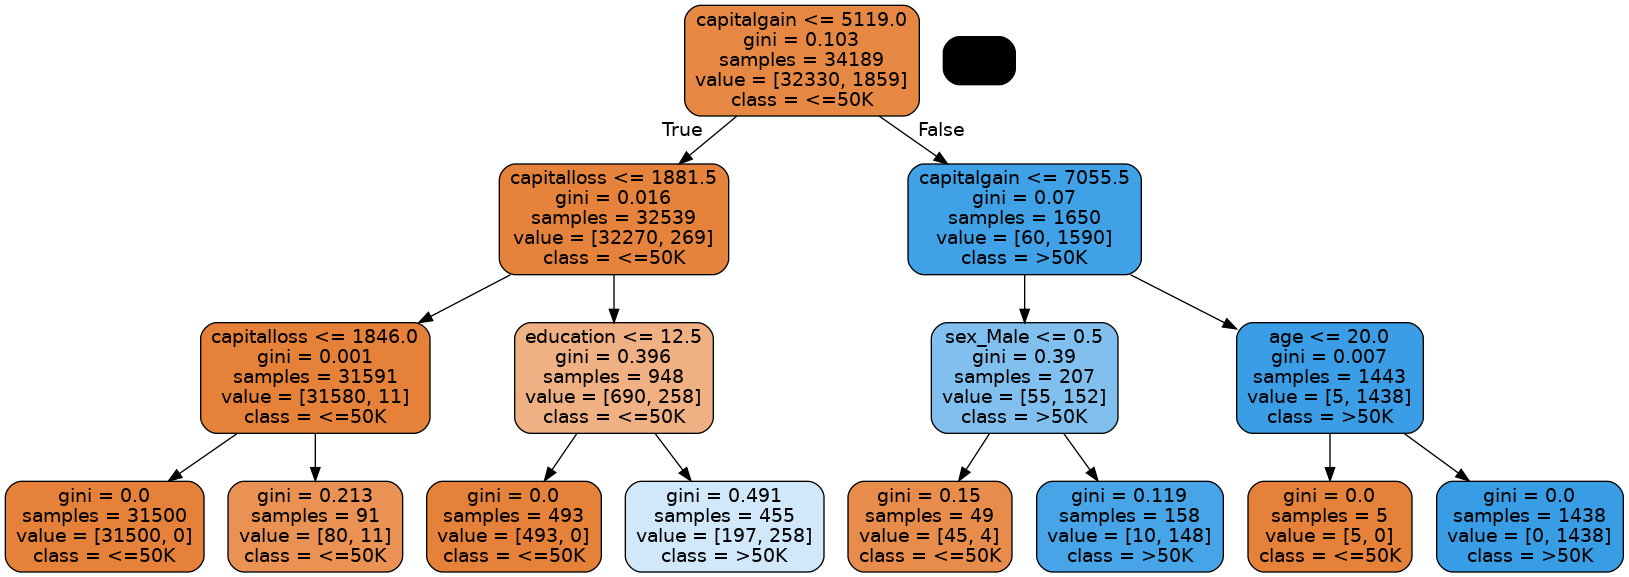

In [10]:
# visualize the decision tree
dot_data = tree.export_graphviz(clf1, out_file=None, 
                                feature_names=encoded_pred_atts, # attributes names
                                class_names=df_code.decode[target], # class labels
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Decision tree paths to CLP rules 

HERE: decision tree model

In [11]:
# Model2CLP
r = reasonx.ReasonX(pred_atts, target, df_code)
r.model(clf1)

In [12]:
# Why was my credit application rejected?
# ANSWER 1

# factual rule on an instance

r.instance('F', features=X1.iloc[0:1], label=y1.iloc[0])
r.solveopt(verbose=2)

---
Answer constraint: F.race=Black,F.sex=Male,F.workclass=Private,F.education=10.0,F.age=19.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=40.0
Rule satisfied by F: IF F.capitalgain<=5119.0,F.capitalloss<=1846.0 THEN <=50K [1.0000]


	Singleton variables: [S1]
	Singleton variables: [S1]


In [13]:
# Why was my credit application rejected?
# ANSWER 2

# counter-factual rules with min conf

print("iter 0")
r.instance('CE', label=1-y1.iloc[0], minconf=0.9)
r.solveopt(verbose=2)
print("iter 1")
r.instance('CE', label=1-y1.iloc[0], minconf=0.8)
r.solveopt(verbose=2)
print("iter 2")
r.instance('CE', label=1-y1.iloc[0], minconf=0.7)
r.solveopt(verbose=2)
print("iter 3")
r.instance('CE', label=1-y1.iloc[0], minconf=0.6)
r.solveopt(verbose=2)

iter 0


	Singleton variables: [S1]
	Singleton variables: [S1]


---
Answer constraint: F.race=Black,F.sex=Male,F.workclass=Private,F.education=10.0,F.age=19.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=40.0,CE.capitalgain>=5119.0,CE.capitalgain<=7055.5,CE.sex_Male>=0.5
Rule satisfied by F: IF F.capitalgain<=5119.0,F.capitalloss<=1846.0 THEN <=50K [1.0000]
Rule satisfied by CE: IF CE.capitalgain>5119.0,CE.capitalgain<=7055.5,CE.sex_Male>0.5 THEN >50K [0.9367]
---
Answer constraint: F.race=Black,F.sex=Male,F.workclass=Private,F.education=10.0,F.age=19.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=40.0,CE.capitalgain>=7055.5,CE.age>=20.0
Rule satisfied by F: IF F.capitalgain<=5119.0,F.capitalloss<=1846.0 THEN <=50K [1.0000]
Rule satisfied by CE: IF CE.capitalgain>7055.5,CE.age>20.0 THEN >50K [1.0000]
iter 1


	Singleton variables: [S1]
	Singleton variables: [S1]


---
Answer constraint: F.race=Black,F.sex=Male,F.workclass=Private,F.education=10.0,F.age=19.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=40.0,CE.capitalgain>=5119.0,CE.capitalgain<=7055.5,CE.sex_Male>=0.5
Rule satisfied by F: IF F.capitalgain<=5119.0,F.capitalloss<=1846.0 THEN <=50K [1.0000]
Rule satisfied by CE: IF CE.capitalgain>5119.0,CE.capitalgain<=7055.5,CE.sex_Male>0.5 THEN >50K [0.9367]
---
Answer constraint: F.race=Black,F.sex=Male,F.workclass=Private,F.education=10.0,F.age=19.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=40.0,CE.capitalgain>=7055.5,CE.age>=20.0
Rule satisfied by F: IF F.capitalgain<=5119.0,F.capitalloss<=1846.0 THEN <=50K [1.0000]
Rule satisfied by CE: IF CE.capitalgain>7055.5,CE.age>20.0 THEN >50K [1.0000]
iter 2


	Singleton variables: [S1]
	Singleton variables: [S1]


---
Answer constraint: F.race=Black,F.sex=Male,F.workclass=Private,F.education=10.0,F.age=19.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=40.0,CE.capitalgain>=5119.0,CE.capitalgain<=7055.5,CE.sex_Male>=0.5
Rule satisfied by F: IF F.capitalgain<=5119.0,F.capitalloss<=1846.0 THEN <=50K [1.0000]
Rule satisfied by CE: IF CE.capitalgain>5119.0,CE.capitalgain<=7055.5,CE.sex_Male>0.5 THEN >50K [0.9367]
---
Answer constraint: F.race=Black,F.sex=Male,F.workclass=Private,F.education=10.0,F.age=19.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=40.0,CE.capitalgain>=7055.5,CE.age>=20.0
Rule satisfied by F: IF F.capitalgain<=5119.0,F.capitalloss<=1846.0 THEN <=50K [1.0000]
Rule satisfied by CE: IF CE.capitalgain>7055.5,CE.age>20.0 THEN >50K [1.0000]
iter 3
---
Answer constraint: F.race=Black,F.sex=Male,F.workclass=Private,F.education=10.0,F.age=19.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=40.0,CE.capitalgain>=5119.0,CE.capitalgain<=7055.5,CE.sex_Male>=0.5
Rule satisfied by F

	Singleton variables: [S1]
	Singleton variables: [S1]


In [14]:
# ADD BGK
# on the age (CF.age = F.age)

r.constraint("CE.age = F.age")
r.solveopt(verbose = 2)

---
Answer constraint: F.race=Black,F.sex=Male,F.workclass=Private,F.education=10.0,F.age=19.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=40.0,CE.age=19.0,CE.capitalgain>=5119.0,CE.capitalgain<=7055.5,CE.sex_Male>=0.5
Rule satisfied by F: IF F.capitalgain<=5119.0,F.capitalloss<=1846.0 THEN <=50K [1.0000]
Rule satisfied by CE: IF CE.capitalgain>5119.0,CE.capitalgain<=7055.5,CE.sex_Male>0.5 THEN >50K [0.9367]


	Singleton variables: [S1]
	Singleton variables: [S1]


In [15]:
# CLOSEST CE

r.solveopt(minimize='l1norm(F, CE)', project=['CE'], verbose = 2)

---
Answer constraint: CE.race=Black,CE.sex=Male,CE.workclass=Private,CE.education=10.0,CE.age=19.0,CE.capitalgain=5118.999999999999,CE.capitalloss=0.0,CE.hoursperweek=40.0
Rule satisfied by F: IF  THEN <=50K [1.0000]
Rule satisfied by CE: IF CE.capitalgain>5119.0,CE.capitalgain<=7055.5,CE.sex_Male>0.5 THEN >50K [0.9367]


	Singleton variables: [S1]
	Singleton variables: [S1]


In [16]:
# UNDER-SPECIFIED INFORMATION

r.retract("F.age=19.0")
r.constraint("F.age<=19.0")
r.solveopt(minimize='l1norm(F, CE)', project=["CE", "F.age"], verbose = 2)

---
Answer constraint: CE.race=Black,CE.sex=Male,CE.workclass=Private,CE.education=10.0,CE.capitalgain=5118.999999999999,CE.capitalloss=0.0,CE.hoursperweek=40.0,F.age<=19.0,CE.age=F.age
Rule satisfied by F: IF  THEN <=50K [1.0000]
Rule satisfied by CE: IF CE.capitalgain>5119.0,CE.capitalgain<=7055.5,CE.sex_Male>0.5 THEN >50K [0.9367]


	Singleton variables: [S1]
	Singleton variables: [S1]


In [17]:
# CHECK data point

X1.iloc[0:1]

,race_AmerIndianEskimo,race_AsianPacIslander,race_Black,race_Other,race_White,sex_Female,sex_Male,workclass_Federalgov,workclass_Localgov,workclass_Neverworked,workclass_Private,workclass_Selfempinc,workclass_Selfempnotinc,workclass_Stategov,workclass_Withoutpay,education,age,capitalgain,capitalloss,hoursperweek
42392,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,10,19,0,0,40
